# Import required packages

In [1]:
import xarray as xr                                                  # handles gridded data
import numpy as np                                                   # numerical functions etc
import pandas as pd                                                  # handles tables of data (.csv, spreadsheets etc)
import re                                                            # allows manipulation of text strings

import matplotlib                                                    # plotting functions generally
import matplotlib.pyplot as plt                                      # specific plotting function we'll use a lot, so we'll give it a shorter name
from matplotlib.patches import Rectangle                             # specific plotting function with an annoyingly long name

import statsmodels.nonparametric.smoothers_lowess as sm_lowess       # nonparametric smoother

import cartopy                                                       # plotting geographical features
import regionmask                                                    # convert shapefile to binary 0,1 mask
import geopandas as gpd                                              # shapefiles

from geopy.geocoders import Nominatim                                # get lat & lon coordinates from a place name
from dateutil.relativedelta import relativedelta                     # calculate differences in times (needed to decode weird timestamps)

# you might get an error like 'ERROR 1: PROJ: proj_create_from_database: Open of /rds/general/user/cb2714/home/anaconda3/envs/wwa/share/proj failed' - you can ignore this!

# HadUK-Grid coordinate system

HadUK-Grid data is provided on a projected (OSGB) coordinate system. That means that the main dimensions aren't lat & lon but `projection_x_coordinate` and `projection_y_coordinate`.  
It also contains more than one variable: as well as the main data variable (in this case, `tasmax`), it also gives the geographic projection and the bounds (edges) of the grid cells and time steps - you can ignore these  

In [2]:
ds = xr.open_dataset("tasmax_hadukgrid_uk_12km_day_19600101-19600131.nc")
ds

<xarray.Dataset> Size: 2MB
Dimensions:                       (time: 31, projection_y_coordinate: 112,
                                   projection_x_coordinate: 82, bnds: 2)
Coordinates:
  * time                          (time) datetime64[ns] 248B 1960-01-01T12:00...
  * projection_y_coordinate       (projection_y_coordinate) float64 896B -1.0...
  * projection_x_coordinate       (projection_x_coordinate) float64 656B -2.1...
    latitude                      (projection_y_coordinate, projection_x_coordinate) float64 73kB ...
    longitude                     (projection_y_coordinate, projection_x_coordinate) float64 73kB ...
Dimensions without coordinates: bnds
Data variables:
    tasmax                        (time, projection_y_coordinate, projection_x_coordinate) float64 2MB ...
    transverse_mercator           int32 4B ...
    time_bnds                     (time, bnds) datetime64[ns] 496B ...
    projection_y_coordinate_bnds  (projection_y_coordinate, bnds) float64 2kB ...
    projection_x_coordinate_bnds  (projection_x_coordinate, bnds) float64 1kB ...
Attributes:
    comment:        Daily resolution gridded climate observations
    creation_date:  2024-05-17T09:46:50
    frequency:      day
    institution:    Met Office
    references:     doi: 10.1002/gdj3.78
    short_name:     daily_maxtemp
    source:         HadUK-Grid_v1.3.0.0
    title:          Gridded surface climate observations data for the UK
    version:        v20240514
    Conventions:    CF-1.7

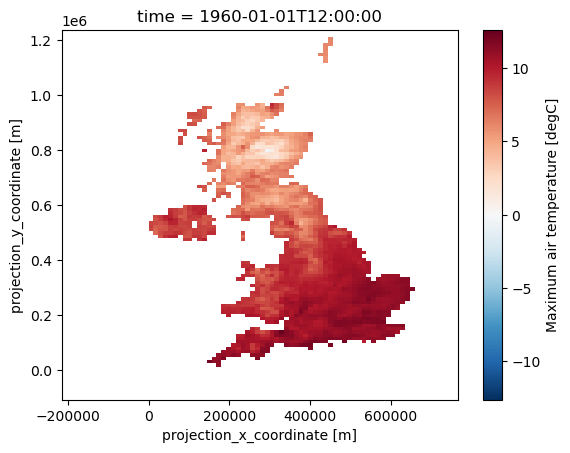

In [3]:
# just select the temperature variable and ignore the rest
ds = ds.tasmax

# HadUK-Grid only contains data over the UK land surface
ds.sel(time = "1960-01-01").plot()

## Adding geographic features to maps

We can use exactly the same plotting functions as for lat-lon data, but we need to tell Python we're using an OSGB projection

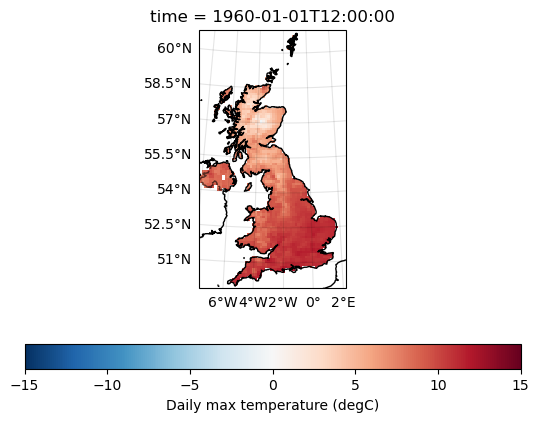

In [4]:
# select a single day of data to plot
ds_event = ds.sel(time = "1960-01-01")

# get the max & min x & y so we can fix the plotting area
data_area = (ds.projection_x_coordinate.min(), ds.projection_x_coordinate.max(), ds.projection_y_coordinate.min(), ds.projection_y_coordinate .max())

# MAKE THE {PLOT}
fig = ds_event.plot(cmap = "RdBu_r",                                                       # colour scheme to use for plotting
                    vmin = -15, vmax = 15,                                                 # set min & max values for colour scale
                    subplot_kws = {"projection" : cartopy.crs.OSGB()},                     # tell it we're using an OSGB projection
                    cbar_kwargs = {"location" : "bottom",                                  # move the colourbar (scale bar) to the bottom
                                   "label" : "Daily max temperature (degC)"})              # relabel the colourbar

# Add some extra labels to the plot
ax = fig.axes                                                                         # give a name to the figure axes so that we can add extra elements
ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)                            # add national borders
ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])                   # add gridlines (note: only implemented for lat-lon gridlines)
ax.coastlines(color = "k")                                                                 # add coastlines

# save the figure for later use
plt.savefig("example-plot.png", bbox_inches = "tight")                                     # bbox_inches removes any white space around the edges of the plot

## Creating a regionmask from a shapefile

Latitude and longitude coordinates are also provided, so if you want to use a shapefile, you can use it to create a mask based on `latitude` and `longitude`.

In [5]:
# load the data and select the 'tasmax' data variable
ds = xr.open_dataset("tasmax_hadukgrid_uk_12km_day_19600101-19600131.nc").tasmax

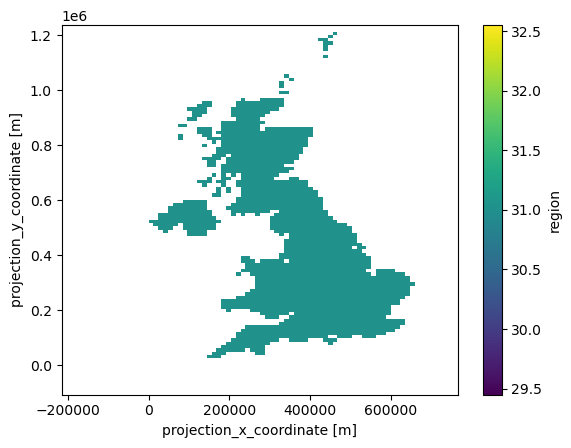

In [6]:
# get the predefined UK/Eire shapefile (you could also load an external shapefile)
sf = regionmask.defined_regions.natural_earth_v5_1_2.countries_50.to_geodataframe()
sf = sf.loc[sf.abbrevs.isin(["GB"])]

# make the regionmask
rm = regionmask.mask_geopandas(sf, ds.longitude, ds.latitude)

# apply the mask to the data (unnecessary when masking the UK only, but here for reference)
ds = ds.where(~np.isnan(rm))

# check that it looks right - the coordinates of the regionmask match the HadUKGrid data
rm.plot()

## Spatial averages
When averaging over a region, instead of averaging over `["lat", "lon"]` you have to average over `["projection_x_coordinate", "projection_x_coordinate"]`. Otherwise, everything's the same.

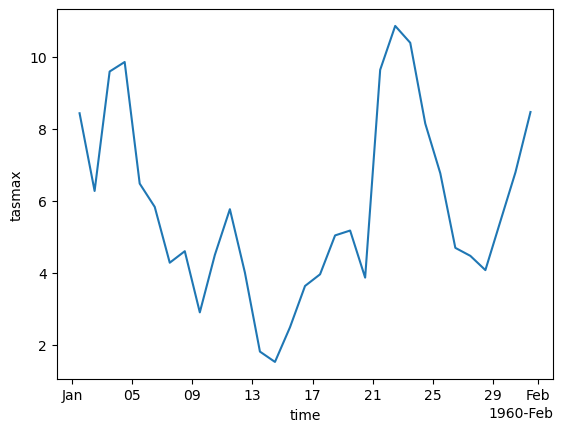

In [7]:
ts = ds.mean(["projection_x_coordinate", "projection_y_coordinate"])
ts.plot()

# Joining files together

Because there's so much of it, the HadUK-Grid data is stored in lots of small files - convenient to download, not so much to work with.  
You can load multiple files that share the same coordinate system together:

In [8]:
ds = xr.open_mfdataset("tasmax_hadukgrid_uk_12km_day_*.nc")
ds

<xarray.Dataset> Size: 5MB
Dimensions:                       (time: 60, projection_y_coordinate: 112,
                                   projection_x_coordinate: 82, bnds: 2)
Coordinates:
  * time                          (time) datetime64[ns] 480B 1960-01-01T12:00...
  * projection_y_coordinate       (projection_y_coordinate) float64 896B -1.0...
  * projection_x_coordinate       (projection_x_coordinate) float64 656B -2.1...
    latitude                      (projection_y_coordinate, projection_x_coordinate) float64 73kB dask.array<chunksize=(112, 82), meta=np.ndarray>
    longitude                     (projection_y_coordinate, projection_x_coordinate) float64 73kB dask.array<chunksize=(112, 82), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    tasmax                        (time, projection_y_coordinate, projection_x_coordinate) float64 4MB dask.array<chunksize=(31, 112, 82), meta=np.ndarray>
    transverse_mercator           (time) int32 240B -2147483647 ... -2147483647
    time_bnds                     (time, bnds) datetime64[ns] 960B dask.array<chunksize=(31, 2), meta=np.ndarray>
    projection_y_coordinate_bnds  (time, projection_y_coordinate, bnds) float64 108kB dask.array<chunksize=(31, 112, 2), meta=np.ndarray>
    projection_x_coordinate_bnds  (time, projection_x_coordinate, bnds) float64 79kB dask.array<chunksize=(31, 82, 2), meta=np.ndarray>
Attributes:
    comment:        Daily resolution gridded climate observations
    creation_date:  2024-05-17T09:46:50
    frequency:      day
    institution:    Met Office
    references:     doi: 10.1002/gdj3.78
    short_name:     daily_maxtemp
    source:         HadUK-Grid_v1.3.0.0
    title:          Gridded surface climate observations data for the UK
    version:        v20240514
    Conventions:    CF-1.7